# Dynamic and non-dynamic solvers

You can choose between a `ivpsolvers.solver_calibrationfree()` (which does not calibrate the output-scale), a `ivpsolvers.solver_mle()` (which calibrates a global output scale via quasi-maximum-likelihood-estimation), and a `ivpsolvers.solver_dynamic()`, which calibrates a time-varying, piecewise constant output-scale via "local' quasi-maximum-likelihood estimation, similar to how ODE solver estimate local errors.

But are these good for?
In short: choose a `solver_dynamic` if your ODE output-scale varies quite strongly, and choose an `solver_mle` otherwise.

For example, consider the numerical solution of a linear ODE with fixed steps:

In [1]:
"""Display the behaviour of the solvers when the scale of the ODE varies."""

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from diffeqzoo import backend, ivps
from jax.config import config

from probdiffeq import ivpsolve
from probdiffeq.impl import impl
from probdiffeq.solvers import calibrated
from probdiffeq.solvers.strategies import filters
from probdiffeq.solvers.strategies.components import corrections, priors
from probdiffeq.util.doc_util import notebook

In [2]:
plt.rcParams.update(notebook.plot_style())
plt.rcParams.update(notebook.plot_sizes())

In [3]:
if not backend.has_been_selected:
    backend.select("jax")  # ivp examples in jax


config.update("jax_platform_name", "cpu")

In [4]:
impl.select("dense", ode_shape=(1,))

In [5]:
f, u0, (t0, t1), f_args = ivps.affine_independent(initial_values=(1.0,), a=2.0)


@jax.jit
def vf(*ys, t):  # noqa: ARG001
    """Evaluate the affine vector field."""
    return f(*ys, *f_args)

In [6]:
num_derivatives = 1

ibm = priors.ibm_adaptive(num_derivatives=1)
ts1 = corrections.ts1()
strategy = filters.filter_adaptive(ibm, ts1)
dynamic = calibrated.dynamic(strategy)
mle = calibrated.mle(strategy)

In [7]:
t0, t1 = 0.0, 3.0
num_pts = 200

ts = jnp.linspace(t0, t1, num=num_pts, endpoint=True)


tcoeffs = (u0, vf(u0, t=t0))
init_mle = mle.initial_condition(tcoeffs, output_scale=1.0)
init_dynamic = dynamic.initial_condition(tcoeffs, output_scale=1.0)
solution_dynamic = ivpsolve.solve_fixed_grid(vf, init_mle, grid=ts, solver=dynamic)
solution_mle = ivpsolve.solve_fixed_grid(vf, init_dynamic, grid=ts, solver=mle)

Plot the solution.

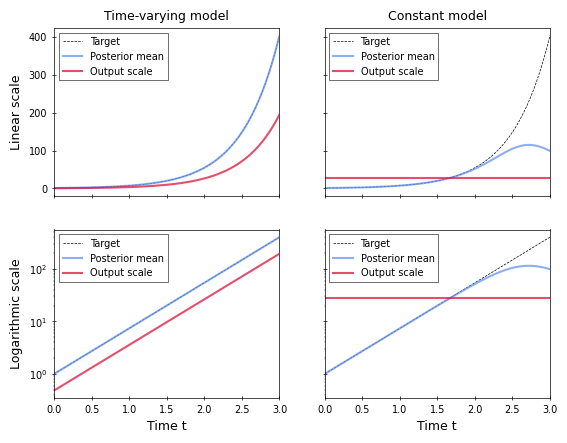

In [8]:
fig, (axes_linear, axes_log) = plt.subplots(ncols=2, nrows=2, sharex=True, sharey="row")


u_dynamic = solution_dynamic.u
u_mle = solution_mle.u
scale_dynamic = solution_dynamic.output_scale
scale_mle = jnp.ones_like(solution_mle.output_scale) * solution_mle.output_scale[-1]

style_target = {
    "marker": "None",
    "label": "Target",
    "color": "black",
    "linewidth": 0.5,
    "alpha": 1,
    "linestyle": "dashed",
}
style_approx = {
    "marker": "None",
    "label": "Posterior mean",
    "color": "C0",
    "linewidth": 1.5,
    "alpha": 0.75,
}
style_scale = {
    "marker": "None",
    "color": "C3",
    "linestyle": "solid",
    "label": "Output scale",
    "linewidth": 1.5,
    "alpha": 0.75,
}

axes_linear[0].set_title("Time-varying model")
axes_linear[0].plot(ts, jnp.exp(ts * 2), **style_target)
axes_linear[0].plot(ts, u_dynamic, **style_approx)
axes_linear[0].plot(ts[1:], scale_dynamic, **style_scale)
axes_linear[0].legend()

axes_linear[1].set_title("Constant model")
axes_linear[1].plot(ts, jnp.exp(ts * 2), **style_target)
axes_linear[1].plot(ts, u_mle, **style_approx)
axes_linear[1].plot(ts[1:], scale_mle, **style_scale)
axes_linear[1].legend()

axes_linear[0].set_ylabel("Linear scale")

axes_linear[0].set_xlim((t0, t1))


axes_log[0].semilogy(ts, jnp.exp(ts * 2), **style_target)
axes_log[0].semilogy(ts, u_dynamic, **style_approx)
axes_log[0].semilogy(ts[1:], scale_dynamic, **style_scale)
axes_log[0].legend()

axes_log[1].semilogy(ts, jnp.exp(ts * 2), **style_target)
axes_log[1].semilogy(ts, u_mle, **style_approx)
axes_log[1].semilogy(ts[1:], scale_mle, **style_scale)
axes_log[1].legend()

axes_log[0].set_ylabel("Logarithmic scale")
axes_log[0].set_xlabel("Time t")
axes_log[1].set_xlabel("Time t")

axes_log[0].set_xlim((t0, t1))

fig.align_ylabels()
plt.show()

The dynamic solver adapts the output-scale so that both the solution and the output-scale grow exponentially.
The ODE-solution fits the truth well.

The solver_mle does not have this tool, and the ODE solution is not able to follow the exponential: it drifts back to the origin. (This is expected, we are basically trying to fit an exponential with a piecewise polynomial.)